
✅ Dataframes loaded!
✅ X shape: torch.Size([1756, 60, 160]), y shape: torch.Size([1756, 10])
StockLSTM(
  (lstm_layers): ModuleList(
    (0): LSTM(160, 128, batch_first=True)
    (1): LSTM(128, 64, batch_first=True)
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)
Training on device: cuda
Epoch [1/3000] - Train Loss: 22.4481, Val Loss: 33.3008
Epoch [10/3000] - Train Loss: 22.0068, Val Loss: 33.8407
Epoch [20/3000] - Train Loss: 22.0897, Val Loss: 33.3284
Epoch [30/3000] - Train Loss: 21.5684, Val Loss: 33.3309
Epoch [40/3000] - Train Loss: 21.1469, Val Loss: 33.3403
Epoch [50/3000] - Train Loss: 21.0501, Val Loss: 33.2467
Epoch [60/3000] - Train Loss: 20.1092, Val Loss: 35.9819
Epoch [70/3000] - Train Loss: 18.8809, Val Loss: 38.5580
Epoch [80/3000] -

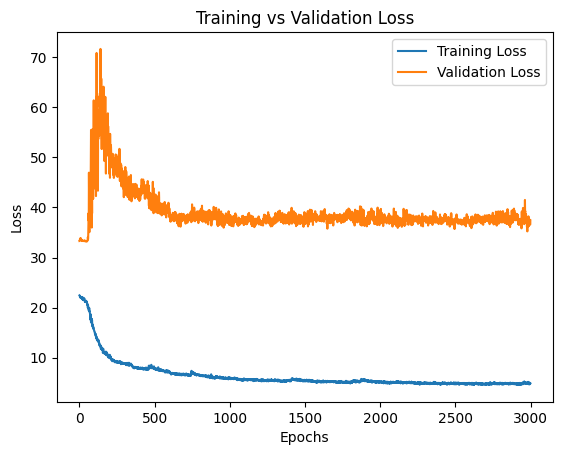

Mean Absolute Error (MAE): 4.1513
Mean Squared Error (MSE): 31.6336
R-squared: -0.1879


In [5]:
# === Cell 1: Load Data ===
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Load datasets
train_df = pd.read_csv('Training/train_2013_2020.csv', parse_dates=["Date"])
valid_df = pd.read_csv('Training/valid_2021_2022.csv', parse_dates=["Date"])
test_df = pd.read_csv('Training/test_2023_2025.csv', parse_dates=["Date"])

print("\n✅ Dataframes loaded!")

# === Cell 2: Preprocessing ===
# Sort and encode tickers
for df in [train_df, valid_df, test_df]:
    df.sort_values(by=["Date", "Ticker"], inplace=True)

label_encoder = LabelEncoder()
train_df['Ticker'] = label_encoder.fit_transform(train_df['Ticker'])
valid_df['Ticker'] = label_encoder.transform(valid_df['Ticker'])
test_df['Ticker'] = label_encoder.transform(test_df['Ticker'])

# Normalize features
feature_cols = train_df.columns.difference(["Date", "5_day_return", "Ticker"])
scaler = MinMaxScaler()
train_df[feature_cols] = scaler.fit_transform(train_df[feature_cols])
valid_df[feature_cols] = scaler.transform(valid_df[feature_cols])
test_df[feature_cols] = scaler.transform(test_df[feature_cols])

# === Cell 3: Sequence Preparation (Multi-stock) ===
def create_multi_stock_sequences(df, window_size=60, num_stocks=10, num_features_per_stock=17):
    df_sorted = df.sort_values(["Date", "Ticker"])
    grouped = df_sorted.groupby("Date")
    dates = sorted(grouped.groups.keys())

    X, y = [], []
    for i in range(window_size, len(dates)):
        window_dates = dates[i - window_size:i]
        target_date = dates[i]

        window_data = []
        for date in window_dates:
            day_data = grouped.get_group(date).sort_values("Ticker")
            features = day_data.drop(columns=["Date", "5_day_return", "Ticker"]).values.flatten()
            window_data.append(features)

        X.append(window_data)

        target_data = grouped.get_group(target_date).sort_values("Ticker")["5_day_return"].values
        y.append(target_data)

    return np.array(X), np.array(y)

num_stocks = len(train_df["Ticker"].unique())
num_features_per_stock = len(feature_cols)

X_train, y_train = create_multi_stock_sequences(train_df, num_stocks=num_stocks, num_features_per_stock=num_features_per_stock)
X_val, y_val = create_multi_stock_sequences(valid_df, num_stocks=num_stocks, num_features_per_stock=num_features_per_stock)
X_test, y_test = create_multi_stock_sequences(test_df, num_stocks=num_stocks, num_features_per_stock=num_features_per_stock)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(f"✅ X shape: {X_train_tensor.shape}, y shape: {y_train_tensor.shape}")

# === Cell 4: Model Definition ===
import torch.nn as nn

class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_sizes=[256, 128, 64], fc_sizes=[64, 32], dropout=0.1):
        super(StockLSTM, self).__init__()

        self.lstm_layers = nn.ModuleList()
        in_size = input_size
        for hidden_size in hidden_sizes:
            self.lstm_layers.append(nn.LSTM(input_size=in_size, hidden_size=hidden_size, batch_first=True))
            in_size = hidden_size

        self.fc_layers = nn.ModuleList()
        for fc_size in fc_sizes:
            self.fc_layers.append(nn.Linear(in_size, fc_size))
            in_size = fc_size

        self.output_layer = nn.Linear(in_size, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        for lstm in self.lstm_layers:
            x, _ = lstm(x)
        x = x[:, -1, :]
        for fc in self.fc_layers:
            x = self.relu(fc(x))
            x = self.dropout(x)
        return self.output_layer(x)

# === Cell 5: Model Initialization ===
input_size = X_train_tensor.shape[2]

# Adjust the structure here:
model = StockLSTM(
    input_size,
    hidden_sizes=[128, 64],  # LSTM layers: list of hidden sizes, one per layer
    fc_sizes=[64, 32],           # Fully connected layers: list of layer sizes
    dropout=0.3                  # Dropout applied after each FC layer (not LSTM layers)
)

print(model)

# === Cell 6: Training ===
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.amp import autocast, GradScaler

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(f"Training on device: {device}")

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scaler = GradScaler()

num_epochs = 3000
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        with autocast(device_type='cuda'):
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            with autocast(device_type='cuda'):
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
            val_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

# === Cell 7: Plot Loss ===
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

# === Cell 8: Evaluation ===
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

y_pred, y_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        y_pred.append(outputs.cpu().numpy())
        y_true.append(y_batch.cpu().numpy())

y_pred = np.concatenate(y_pred, axis=0)
y_true = np.concatenate(y_true, axis=0)

mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
mse = mean_squared_error(y_true.flatten(), y_pred.flatten())
r2 = r2_score(y_true.flatten(), y_pred.flatten())

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")



📊 Evaluation Results:
Mean Absolute Error (MAE): 4.1513
Mean Squared Error (MSE): 31.6336
R-squared: -0.1879


/tmp/ipykernel_9287/3846898642.py:39: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/jesse/Projects/myenvs/torch_nightly/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


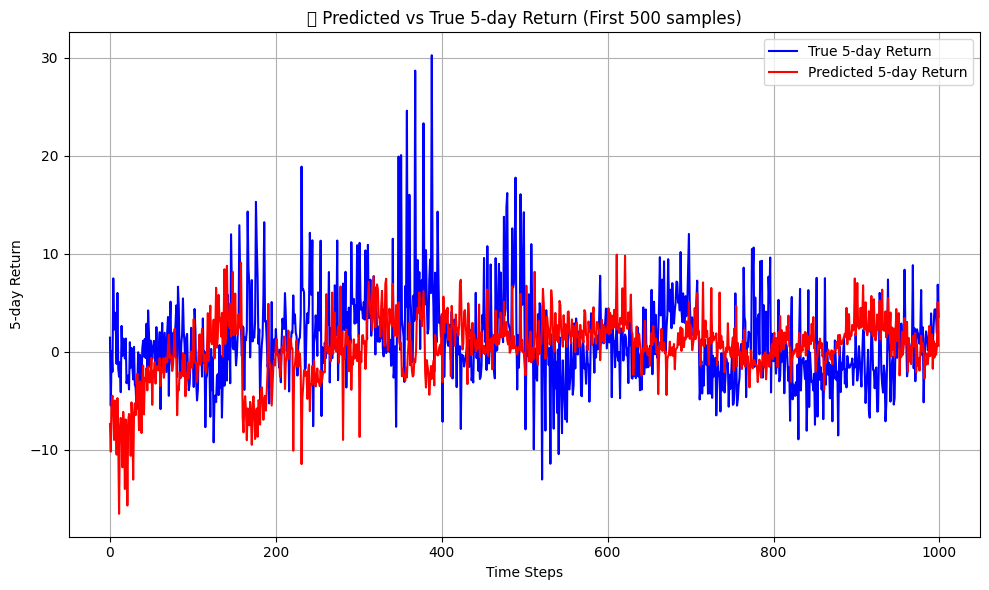

In [6]:
# ==== Cell 8: Evaluation and Visualization ====
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

model.eval()
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

y_pred, y_true = [], []
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        y_pred.extend(outputs.cpu().numpy())
        y_true.extend(y_batch.cpu().numpy())

y_pred = np.array(y_pred).flatten()
y_true = np.array(y_true).flatten()

# Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"\n📊 Evaluation Results:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# Plotting predicted vs true values (for first 1000 time steps)
plt.figure(figsize=(10, 6))
plt.plot(y_true[:1000], label="True 5-day Return", color='blue')
plt.plot(y_pred[:1000], label="Predicted 5-day Return", color='red')
plt.title("📈 Predicted vs True 5-day Return (First 500 samples)")
plt.xlabel("Time Steps")
plt.ylabel("5-day Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
